## Time Series Mini Project

In [1]:
# imports
import pandas as pd
import requests
import acquire
import prepare
import project
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import strftime
from statsmodels.tsa.api import Holt

In [2]:
plt.rc('figure', figsize=(13, 6))
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=13)

### Assignment
The goal of this mini-project is to practice what you have learned at each stage of the pipeline throughout the time series module. You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful).



Use the data from this kaggle competition: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

There will not be a presentation, but be sure and have a final notebook that someone could quickly review to see what you found. Don't forget the planning stage! Practice all the techniques and best practices you have been taught and have been using in each module thus far. 

Create a notebook within your existing time series exercises repository.

Submit a link to your final notebook.

### Project Planning
1. Pick a city / state from data set
2. Acquire the data
3. Explore the unclean data to determine Data Prep Need To
4. Prepare / clean / tidy the data for splitting / exploration
5. Pick a reasonable splitting point and split into train / test datasets
6. Explore the train dataset
    - Look at Daily / Weekly / Monthly / Quarterly / Yearly trends / cycles
    - Visualize changes over time
    - Visualize a seasonal cycle
    - Show lag plots / Auto-correlation / Decomposition / Mas
7. Build at least 3 Models (Simple Average, Moving Average, Holt's Linear Trend, Change timeframe based-on)
8. Evaluate Models, adjust hyperparameters and pick best model to evaluate on test
9. Conclusions / Takeaways / Next Steps

### Data Wrangling
#### Goals:
- Bring in Data for Raleigh, NC
- Convert 'dt' column to DateTime, and reset to Index
- Drop null values
- drop unneccessary columns
- rename columns for ease of use
- return a clean pandas DataFrame ready for exploration

In [3]:
df = project.get_raleigh()

In [4]:
df = project.initial_prep(df, 'dt')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1365 entries, 1900-01-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_temp              1365 non-null   float64
 1   avg_temp_uncertainty  1365 non-null   float64
dtypes: float64(2)
memory usage: 32.0 KB


In [6]:
df.head()

,avg_temp,avg_temp_uncertainty
dt,,
1900-01-01,3.569,0.504
1900-02-01,2.909,0.813
1900-03-01,7.374,0.459
1900-04-01,13.868,0.445
1900-05-01,19.408,0.572


In [7]:
df.describe()

,avg_temp,avg_temp_uncertainty
count,1365.000000,1365.000000
mean,14.722171,0.298994
std,7.912140,0.121169
min,-2.690000,0.062000
25%,7.672000,0.215000
50%,14.759000,0.280000
75%,22.512000,0.353000
max,28.089000,0.943000


In [8]:
df.index.min(), df.index.max()

(Timestamp('1900-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

In [9]:
df.index.nunique()

1365

In [10]:
df = project.add_month_col(df)

In [11]:
df.head(1092)

,avg_temp,avg_temp_uncertainty,month
dt,,,
1900-01-01,3.569,0.504,01-Jan
1900-02-01,2.909,0.813,02-Feb
1900-03-01,7.374,0.459,03-Mar
1900-04-01,13.868,0.445,04-Apr
1900-05-01,19.408,0.572,05-May
...,...,...,...
1990-08-01,25.153,0.235,08-Aug
1990-09-01,21.496,0.227,09-Sep
1990-10-01,16.414,0.289,10-Oct


In [12]:
# Let's split into train and test
# we will use the 80-20 method (roughly)

train = df.loc[:'1990']
test = df.loc['1991':]

In [13]:
# did I lose any data?
train.shape, test.shape

((1092, 3), (273, 3))

In [14]:
train.index.min(), train.index.max()

(Timestamp('1900-01-01 00:00:00'), Timestamp('1990-12-01 00:00:00'))

In [15]:
test.index.min(), test.index.max()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

#### Data Wrangling Takeaways:
- I now have a clean dataset of 3119 observations
- from 1743 to 2013
- A small percentage of months are missing, but it shouldn't impact results
- The train set has 2498 observations from 1743 to 1961
- The test set has 621 observations from 1962 to 2013

### Data Exploration
#### Goals:
- Visualize the data in different ways to look for:
    - Overall trend
    - Seasonal trends
    - Unique observations
- 
    

In [16]:
df = project.add_month_col(df)

In [17]:
# set a target variable to plot / explore
y = train['avg_temp']

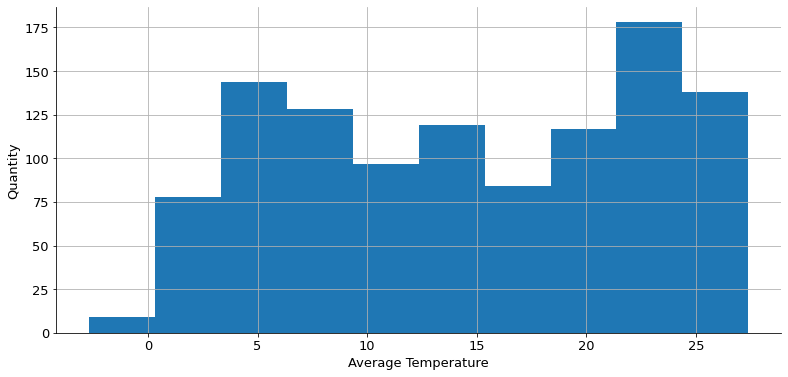

In [18]:
y.hist()
plt.xlabel('Average Temperature')
plt.ylabel('Quantity')
plt.show()

#### Histogram Takeaways:
- Clear bimodality suggesting two distinct curves to complete one season
- Appears to be a slightly wider spread of colder temperatures

<AxesSubplot:xlabel='dt'>

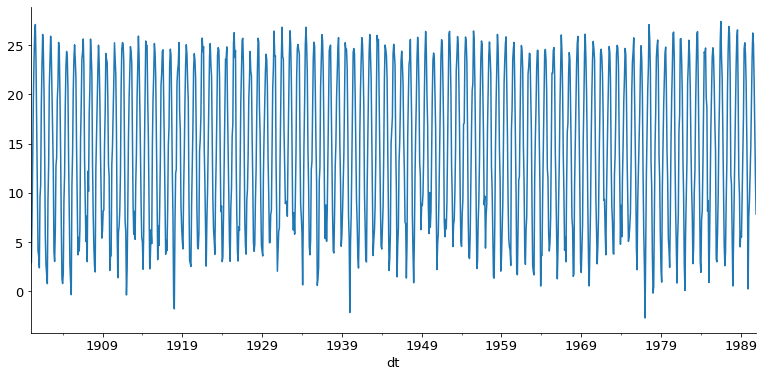

In [19]:
# what does it look like over time, as is?
y.plot()

Lots of noise when looking at the data as is

<AxesSubplot:xlabel='dt'>

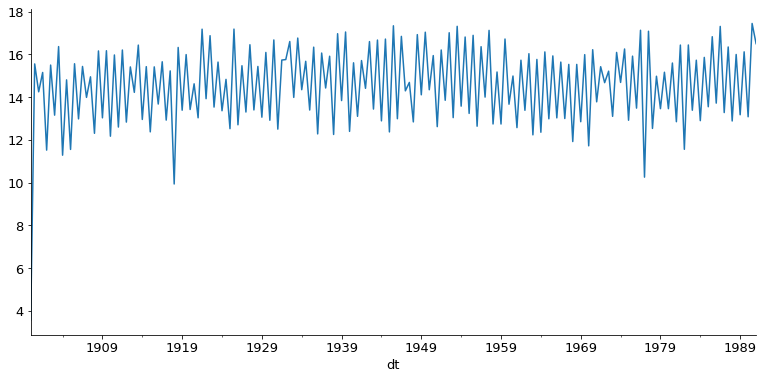

In [20]:
y.resample('6M').mean().plot()

Much less noise when looking at 6 month samples

<AxesSubplot:xlabel='dt'>

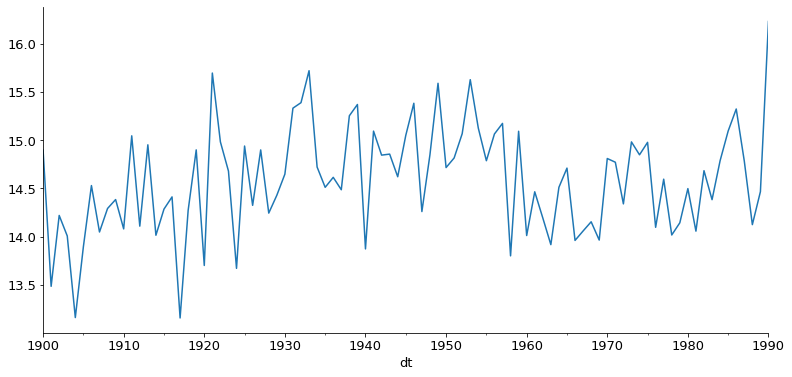

In [21]:
y.resample('Y').mean().plot()

Once broken into 1 year segments, we start to see a mostly upward trend

<AxesSubplot:xlabel='dt'>

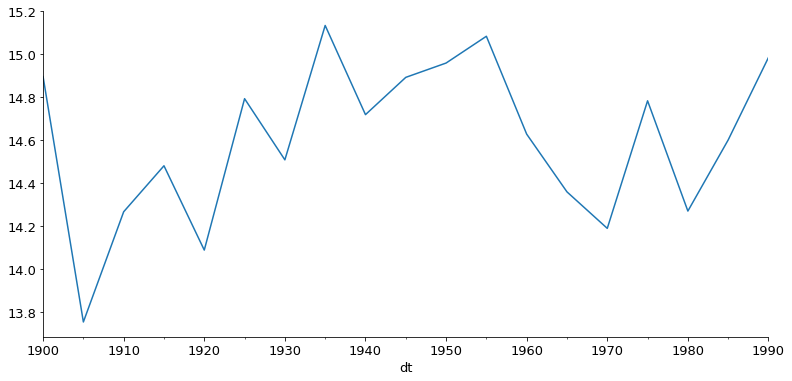

In [22]:
y.resample('5Y').mean().plot()

5 year average looks to be the best bet as far as detecting trends

<AxesSubplot:xlabel='dt'>

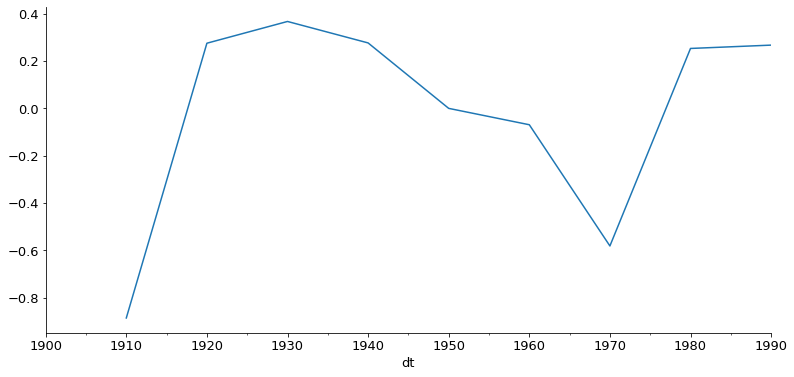

In [23]:
y.resample('10Y').mean().diff().plot()

10 year appears to have gone too far

<AxesSubplot:xlabel='month'>

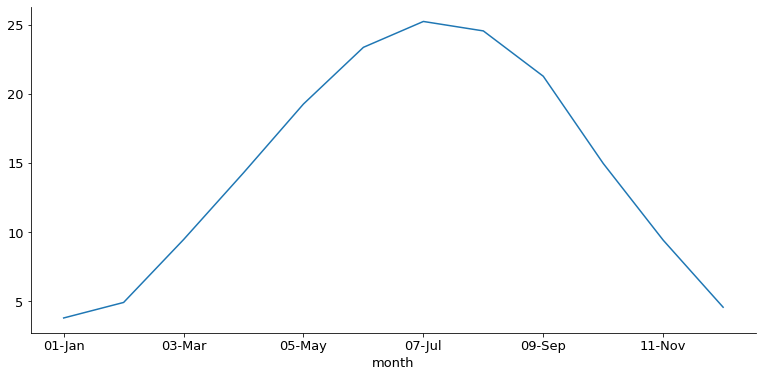

In [24]:
train.groupby('month').mean().avg_temp.plot()

<AxesSubplot:ylabel='dt'>

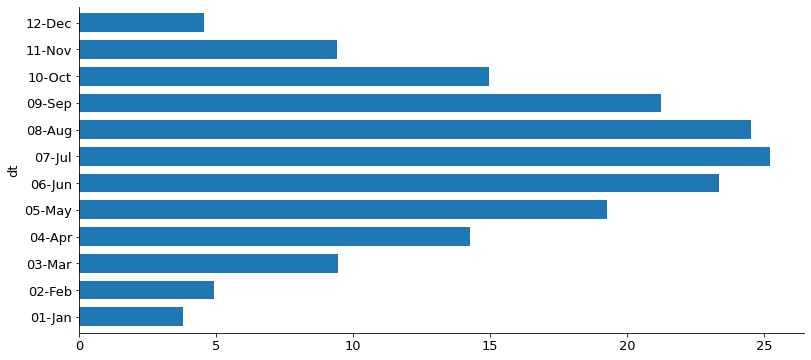

In [25]:
y.groupby(y.index.strftime('%m-%b')).mean().plot.barh(width=.7)

- Clear seasonality showing a peak in the summer months, and valley in the winter
- Exactly what we would expect to see

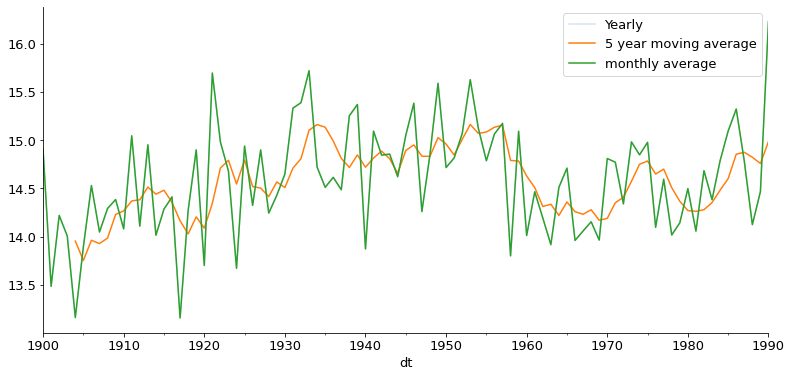

In [26]:
ax = y.resample('Y').mean().plot(label='Yearly', alpha=.2)
y.resample('Y').mean().rolling(5).mean().plot(ax=ax, label='5 year moving average')
y.resample('Y').mean().plot(ax=ax, label='monthly average')
ax.legend()

<AxesSubplot:xlabel='dt'>

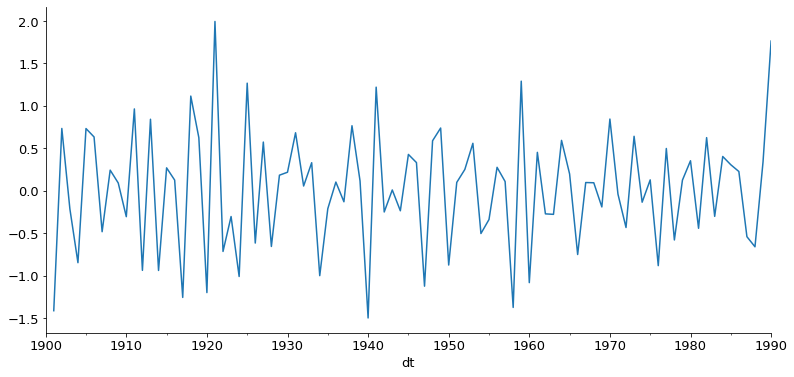

In [27]:
y.resample('Y').mean().diff().plot()

<AxesSubplot:xlabel='dt'>

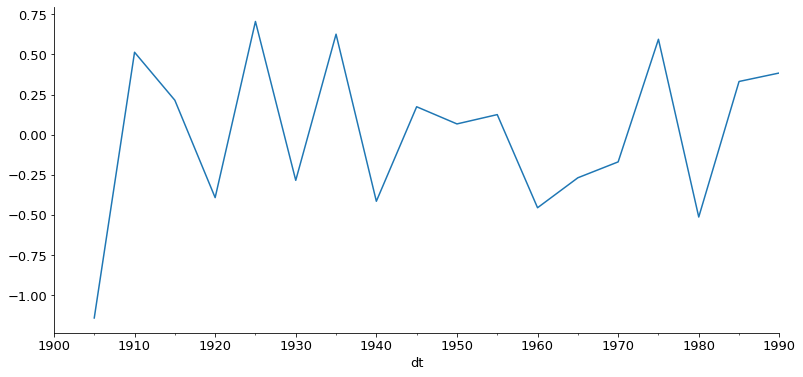

In [28]:
y.resample('5Y').mean().diff().plot()

<AxesSubplot:xlabel='dt'>

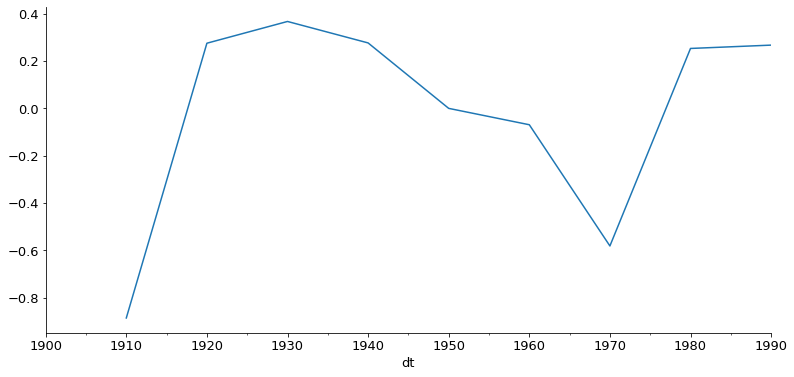

In [29]:
y.resample('10Y').mean().diff().plot()

- Same takeaways from plotting differences
- The 1 year still has lots of noise/fluctuation
- The 5 year seems to offer the most insight / pattern detection

### Let's Find Some Seasonality

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

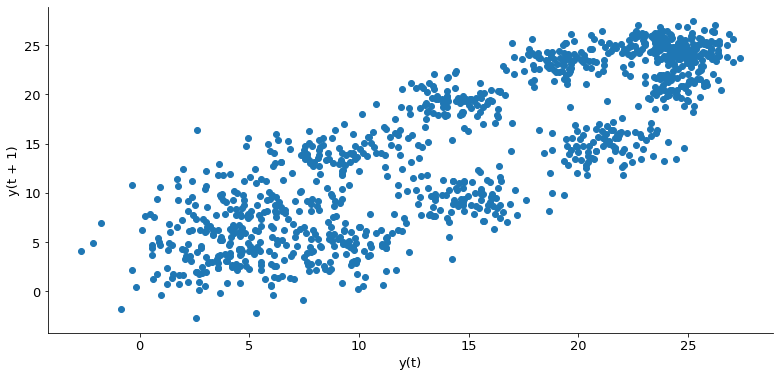

In [30]:
# How does it project 1 month out?
pd.plotting.lag_plot(y.resample('M').mean(), 1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>

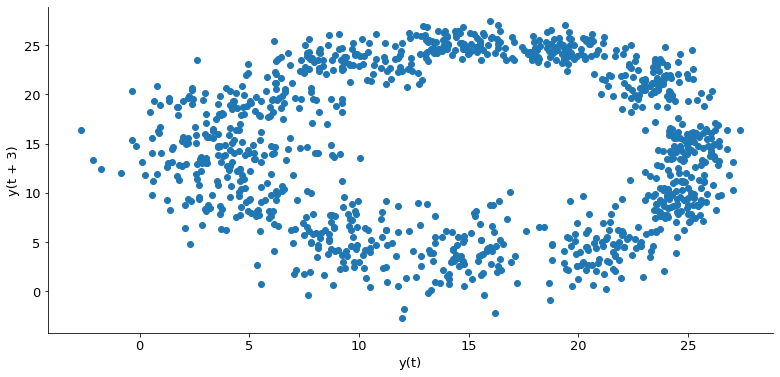

In [31]:
# How does it project 3 months out?
pd.plotting.lag_plot(y.resample('M').mean(), 3)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 6)'>

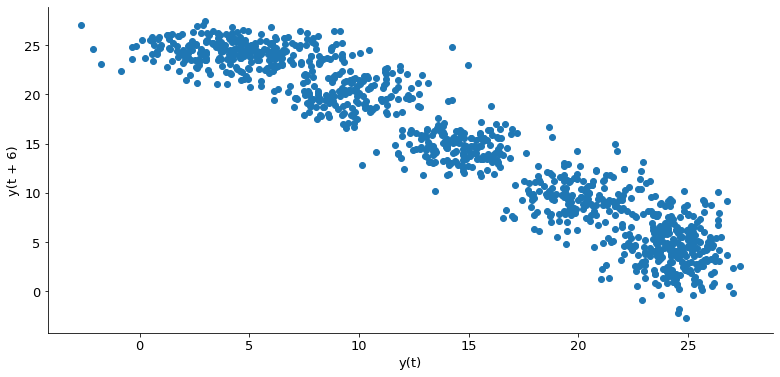

In [32]:
# How does it project 6 months out?
pd.plotting.lag_plot(y.resample('M').mean(), 6)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 9)'>

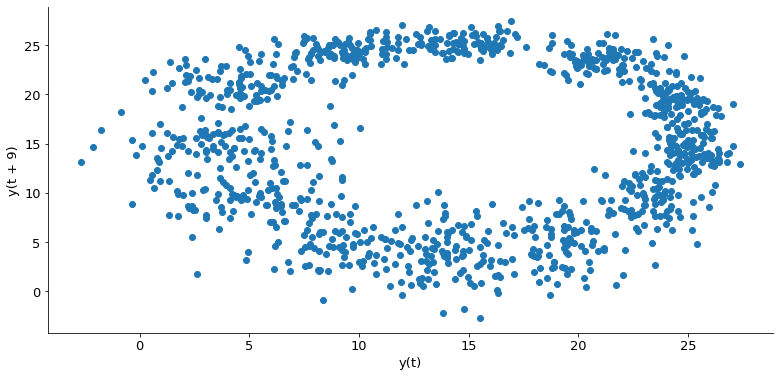

In [33]:
# How does it project 9 months out?
pd.plotting.lag_plot(y.resample('M').mean(), 9)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 12)'>

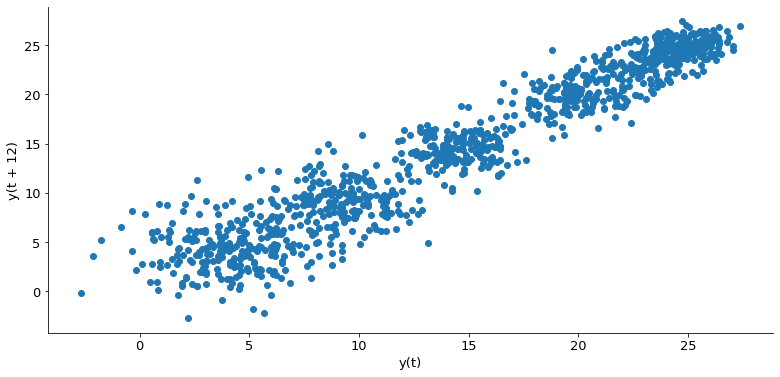

In [34]:
# How does it project 12 months out?
pd.plotting.lag_plot(y.resample('M').mean(), 12)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 24)'>

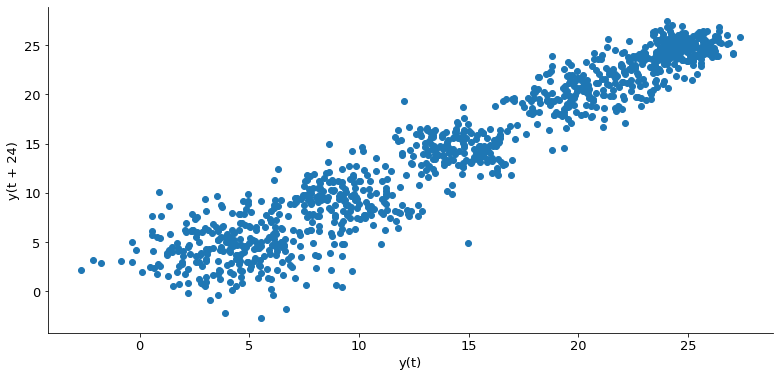

In [35]:
# How does it project 24 months out?
pd.plotting.lag_plot(y.resample('M').mean(), 24)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 36)'>

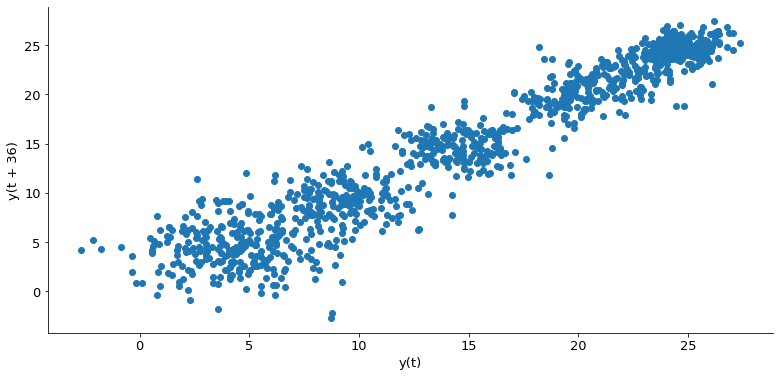

In [36]:
# How does it project 36 months out?
pd.plotting.lag_plot(y.resample('M').mean(), 36)

In [37]:
autocorr = pd.Series({lag: project.correlation(y.resample('Y').mean(), lag) for lag in range(1, 10)})
autocorr

1    0.180989
2    0.213884
3    0.256356
4    0.149764
5    0.109609
6    0.137048
7    0.049528
8    0.134574
9   -0.067094
dtype: float64

<AxesSubplot:>

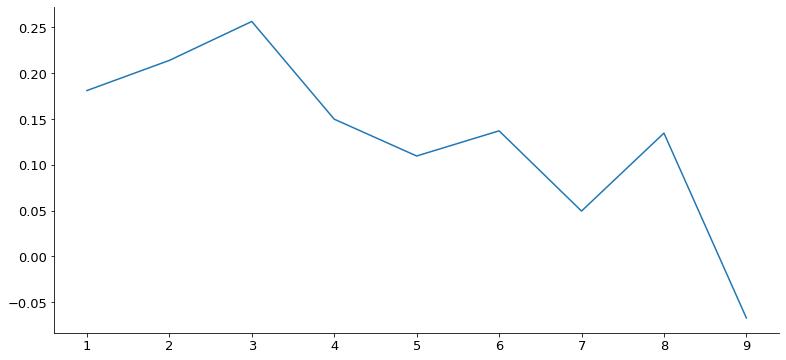

In [38]:
autocorr.plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

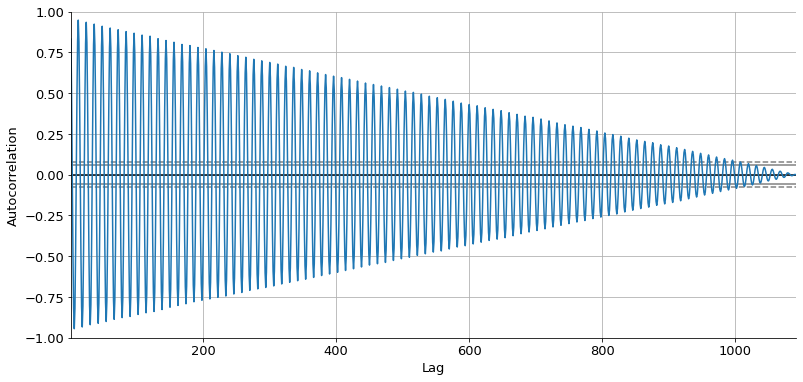

In [39]:
pd.plotting.autocorrelation_plot(y.resample('M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

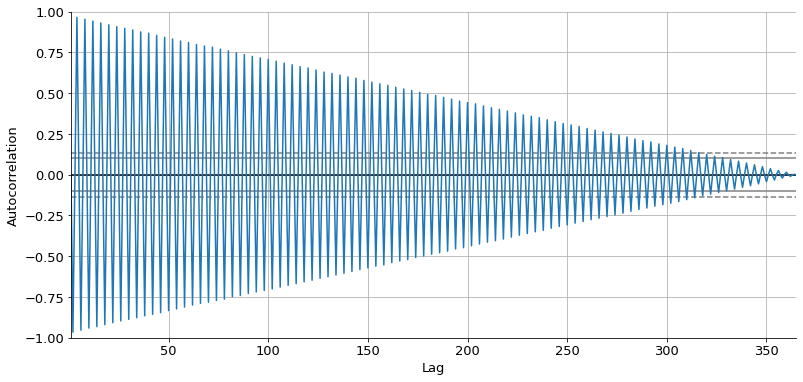

In [40]:
pd.plotting.autocorrelation_plot(y.resample('3M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

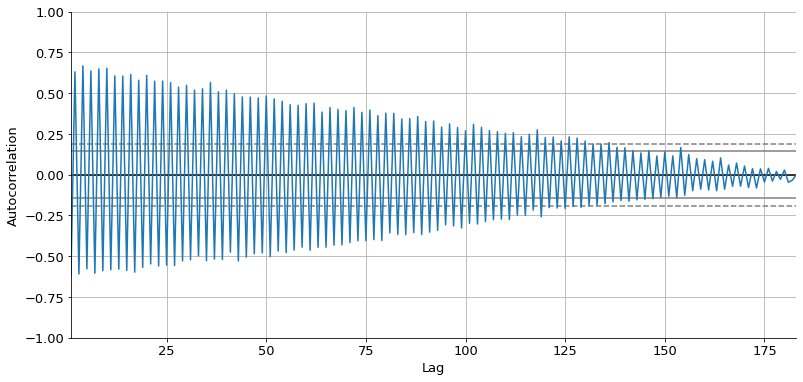

In [41]:
pd.plotting.autocorrelation_plot(y.resample('6M').mean())

#### Autocorrelation Takeaways:
- Whether resampling by month, 3/6/9 months, there is clear correlation at peaks/valleys of the seasonal cycle
- IE., this can be useful at predicting at 6 month intervals, with less accuracy at each interval into the future

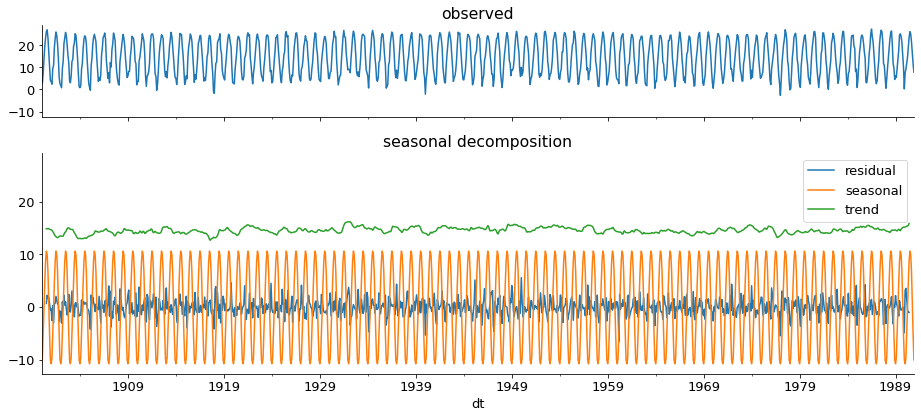

In [42]:
import statsmodels.api as sm

s = y.resample('M').mean()

# url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
# df = pd.read_csv(url, index_col='Date', parse_dates=True)
# s = df.Solar.dropna().resample('W').mean().ffill()

result = sm.tsa.seasonal_decompose(s, model='additive')
result = pd.DataFrame(dict(
    observed=result.observed,
    residual=result.resid,
    seasonal=result.seasonal,
    trend=result.trend
))
gs = plt.GridSpec(3, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[1:])
ax2 = fig.add_subplot(gs[0], sharex=ax1, sharey=ax1)
result.iloc[:, 1:].plot(ax=ax1, title='seasonal decomposition')
result.observed.plot(ax=ax2, title='observed')
fig.tight_layout()

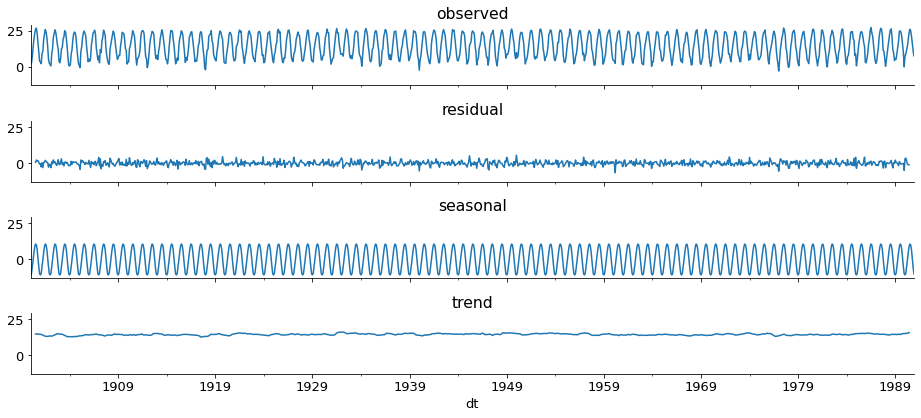

In [43]:
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
for ax, (col, x) in zip(axs, result.iteritems()):
    x.plot(ax=ax, title=col)
fig.tight_layout()

### Data Exploration Takeaways:
- Clear 12 month Seasonality
    - Temperatures peak in the summer, and dip in the winter
    - Appear to be able to reliably predict in 6 month intervals
- Too much data to see a clear trend
- With more time, I would trim the data set to only include the last 50 years of data to see iif that would improve trendline

### Model Building
#### Goals:
- Resplit data to accommodate train/validate/test datasets
- Establish a baseline model, and measure it RMSE
- Create at least 3 models and evaluate them on the train dataset, and test on validate
- Adjust hyperparameters and verify best model on the test dataset
- Draw conclusions, takeways, key findings, and next steps

In [44]:
# let's resplit the data in a meaningful way
# set train size to 50%
train_size = int(len(df) * 0.5)
train_size

682

In [45]:
# set validate size to 30%
validate_size = int(len(df) * 0.3)
validate_size

409

In [46]:
# set test size to 20%
test_size = int(len(df) - train_size - validate_size)
test_size

274

In [47]:
## validate will go from 912 to 682+409
validate_end_index = train_size + validate_size
validate_end_index

1091

In [48]:
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

In [49]:
# is len of train + validate + test == length of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


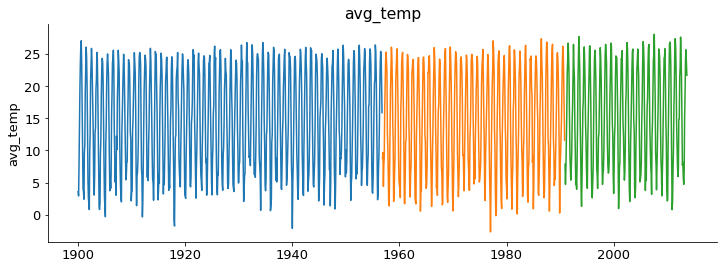

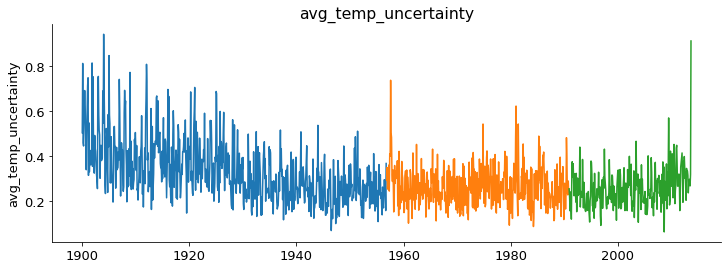

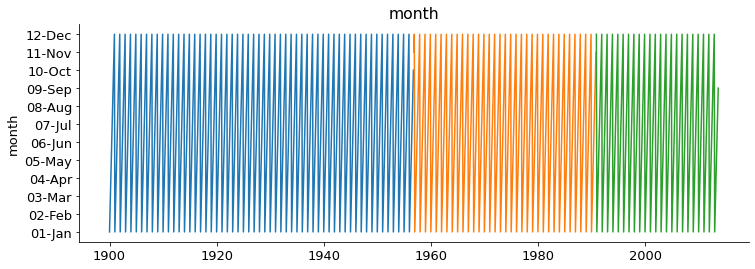

In [50]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### What does it mean?
- Much more uncertainty in older data, which makes sense
- If more time, would probably eliminate older data, and just use newer to more accurately predict the future
- A few Spikes in uncertainty around (1958, 1982) are worth investigating 

In [51]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [52]:
# take the last item of avg_temp and assign to variable
last_temp = round(train['avg_temp'][-1:][0], 3)
last_temp

15.875

In [53]:
yhat_df = pd.DataFrame({'avg_temp': [last_temp]}, 
                      index = validate.index)

yhat_df.head()

,avg_temp
dt,
1956-11-01,15.875
1956-12-01,15.875
1957-01-01,15.875
1957-02-01,15.875
1957-03-01,15.875


In [54]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [55]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [56]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

avg_temp -- RMSE: 8


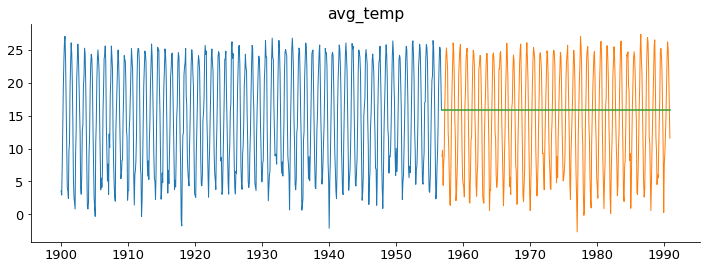

In [57]:
plot_and_eval('avg_temp')

In [58]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'avg_temp')

In [59]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0


#### Now let's look at simple average

In [60]:
# compute simple average
avg_avg_temp = round(train['avg_temp'].mean(), 3)
avg_avg_temp

14.635

In [61]:
def make_predictions():
    yhat_df = pd.DataFrame({'avg_temp': [avg_avg_temp]},
                          index=validate.index)
    return yhat_df

In [62]:
yhat_df = make_predictions()

avg_temp -- RMSE: 8


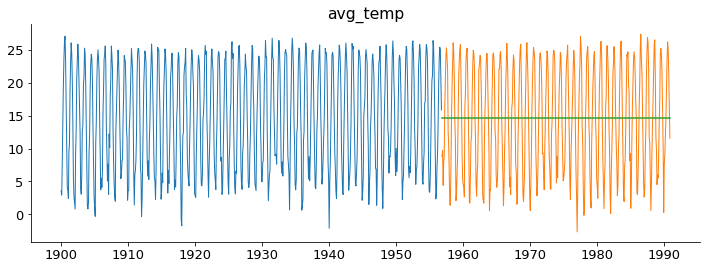

In [63]:
plot_and_eval('avg_temp')

In [64]:
eval_df = append_eval_df(model_type='simple_average', target_var = 'avg_temp')

In [65]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0


#### Moving Average

In [66]:
period = 3 

# take 3 month rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
avg_temp_3 = round(train['avg_temp'].rolling(period).mean()[-1], 3)
print(avg_temp_3)

20.371


In [67]:
yhat_df = make_predictions()

avg_temp -- RMSE: 8


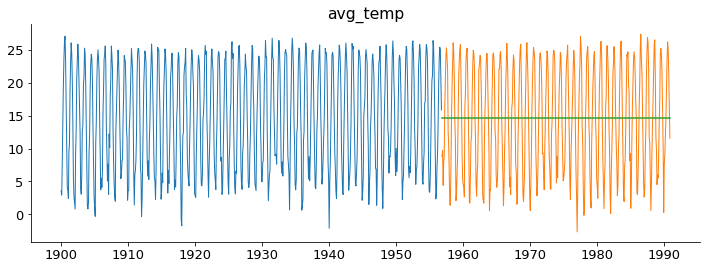

In [68]:
plot_and_eval('avg_temp')

In [69]:
eval_df = append_eval_df(model_type = '3mo_moving_avg', target_var = 'avg_temp')

In [70]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
2,3mo_moving_avg,avg_temp,8.0


In [71]:
periods = [6, 9, 12, 18, 24]

for p in periods: 
    roll_avg = round(train['avg_temp'].rolling(p).mean()[-1], 3)
    yhat_df = make_predictions()
    model_type = str(p) + 'mo_moving_avg'
    eval_df = append_eval_df(model_type = model_type, 
                                 target_var = 'avg_temp')

In [72]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
2,3mo_moving_avg,avg_temp,8.0
3,6mo_moving_avg,avg_temp,8.0
4,9mo_moving_avg,avg_temp,8.0
5,12mo_moving_avg,avg_temp,8.0
6,18mo_moving_avg,avg_temp,8.0
7,24mo_moving_avg,avg_temp,8.0


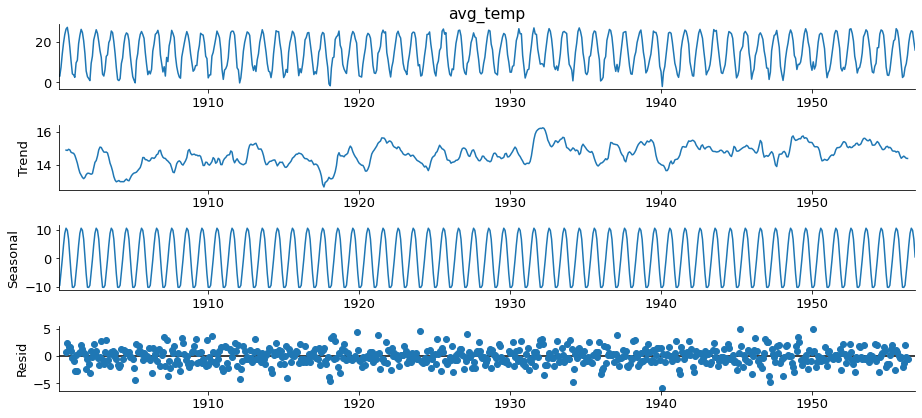

In [73]:
sm.tsa.seasonal_decompose(train['avg_temp'].resample('M').mean()).plot()
plt.show()

In [74]:
model = Holt(train['avg_temp'], exponential=False, damped=True)
model = model.fit(optimized=True)
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
yhat_df['avg_temp'] = round(yhat_items, 3)

<ipython-input-74-1793585e4c17>:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model = Holt(train['avg_temp'], exponential=False, damped=True)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


avg_temp -- RMSE: 18


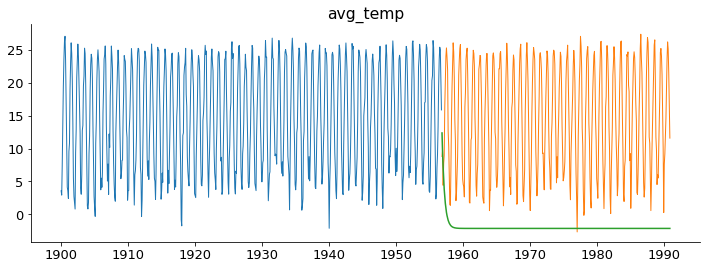

In [75]:
plot_and_eval(target_var = 'avg_temp')

In [76]:
eval_df = append_eval_df(model_type = 'holts_optimized', target_var = 'avg_temp')

In [77]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
2,3mo_moving_avg,avg_temp,8.0
3,6mo_moving_avg,avg_temp,8.0
4,9mo_moving_avg,avg_temp,8.0
5,12mo_moving_avg,avg_temp,8.0
6,18mo_moving_avg,avg_temp,8.0
7,24mo_moving_avg,avg_temp,8.0
8,holts_optimized,avg_temp,18.0


In [78]:
model = Holt(train['avg_temp'], exponential=False)
model = model.fit(smoothing_level=0.1,
                      smoothing_slope=0.1,
                      optimized=False)
yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
yhat_df['avg_temp'] = round(yhat_items, 3)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-78-2bc5772d430d>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model = model.fit(smoothing_level=0.1,


In [79]:
eval_df = append_eval_df(model_type = 'holts_optimized_1', target_var = 'avg_temp')

In [80]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
2,3mo_moving_avg,avg_temp,8.0
3,6mo_moving_avg,avg_temp,8.0
4,9mo_moving_avg,avg_temp,8.0
5,12mo_moving_avg,avg_temp,8.0
6,18mo_moving_avg,avg_temp,8.0
7,24mo_moving_avg,avg_temp,8.0
8,holts_optimized,avg_temp,18.0
9,holts_optimized_1,avg_temp,45.0


avg_temp -- RMSE: 45


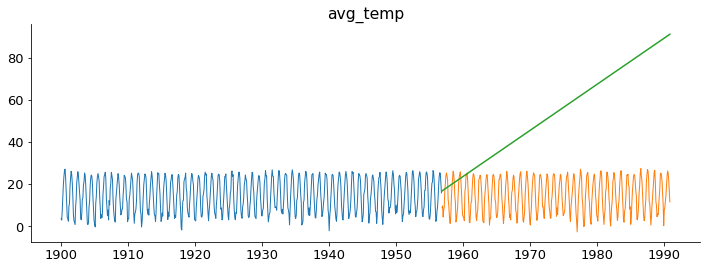

In [81]:
plot_and_eval('avg_temp')

In [82]:
model = Holt(train['avg_temp'], exponential=False)
model = model.fit(smoothing_level=0.5,
                      smoothing_slope=0.5,
                      optimized=False)
yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
yhat_df['avg_temp'] = round(yhat_items, 3)

/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/homebrew/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-82-aedfd3eca5e3>:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  model = model.fit(smoothing_level=0.5,


In [83]:
eval_df = append_eval_df(model_type = 'holts_optimized_2', target_var = 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,8.0
1,simple_average,avg_temp,8.0
2,3mo_moving_avg,avg_temp,8.0
3,6mo_moving_avg,avg_temp,8.0
4,9mo_moving_avg,avg_temp,8.0
5,12mo_moving_avg,avg_temp,8.0
6,18mo_moving_avg,avg_temp,8.0
7,24mo_moving_avg,avg_temp,8.0
8,holts_optimized,avg_temp,18.0
9,holts_optimized_1,avg_temp,45.0


### Takeaways so far:
- None of these models are of much values
- The Holt models are especially off
- Going to try re-splitting, and seeing if year over year leads me anywhere better

In [84]:
df = df.drop(columns=(['month', 'avg_temp_uncertainty']))

In [85]:
train = df['2010']
validate = df['2011']
test = df['2012']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(12, 1)
(12, 1)
(12, 1)


,avg_temp
dt,
2010-08-01,26.295
2010-09-01,23.305
2010-10-01,16.049
2010-11-01,9.580
2010-12-01,0.768


In [86]:
## finding the year-over-year difference for each month from 2007 to 2009
# taking the mean, and then adding that value to the monthly 2007 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2010'] + train.diff(12).mean()

In [87]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [91]:
test

,avg_temp
dt,
2012-01-01,5.916
2012-02-01,7.129
2012-03-01,14.806
2012-04-01,14.876
2012-05-01,21.443
2012-06-01,22.982
2012-07-01,27.656
2012-08-01,24.858
2012-09-01,21.137


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

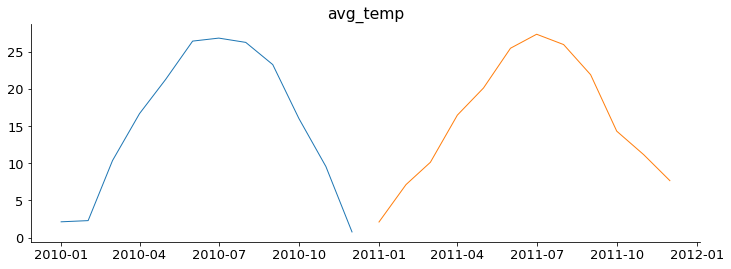

In [88]:
plot_and_eval(target_var = 'avg_temp')
eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = 'avg_temp')

### Conclusion
#### Key Findings, Takeaways, & Next Steps:
- So far, none of my models are successful at forecasting future temperature
- There appear to be some issues with data integrity:
    - Change in thermometers used over time
    - Questionable reliability of data (The much higher degree of uncertainty 200 years ago)
    - Global/Local events that lead to dramatic changes in certain years??
- I would like to gather more data from other cities around Raleigh, and look at the last 60 years
    - There is clear seasonality of 12 months in this data, and it looks like the overall trend is actually somewhat cyclical as well
    - I have identified the 12 month cycle, my next goal is to identify the 10/20/x year larger cycle (if one exists) and use this information to better identify any overall trend
    - I would look at yearly average, instead of monthly to identify this larger season
- And lastly, I would like to spend more time adjusting hyperparameters on my models to optimize performance